# Example Training for Normalizing Flows

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

from utils.train_utils import train_density_estimation, nll
from normalizingflows.flow_catalog import RealNVP
from data.data_manager import Dataset

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1234)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

tensorflow:  2.8.0
tensorflow-probability:  0.16.0


/home/marcel/Repos/normalizing-flows/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

In [2]:
batch_size = 1000
dataset_name = 'activations'

In [3]:
dataset = Dataset(dataset_name, batch_size=batch_size)
batched_train_data, val_data, test_data = dataset.get_data()

2022-03-27 18:41:57.086434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 18:41:57.092840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 18:41:57.107965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 18:41:57.108661: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 2. Build the Normalizing Flow


In [4]:
layers = 5
dimensions = 100
hidden_units = [256, 256]

In [5]:
def create_flow(training: bool):
    bijectors = []
    base_dist = tfd.Normal(loc=0.0, scale=1.0)
    permutation = np.flip(np.arange(0, dimensions))
    for i in range(layers):
        bijectors.append(tfb.BatchNormalization(training=training))
        bijectors.append(RealNVP(input_shape=dimensions, n_hidden=hidden_units))
        bijectors.append(tfp.bijectors.Permute(permutation))

    bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_real_nvp')
    return tfd.TransformedDistribution(
        distribution=tfd.Sample(base_dist, sample_shape=[dimensions]),
        bijector=bijector
    )

In [6]:
flow = create_flow(training=True)
n_trainable_variables = len(flow.trainable_variables)

2022-03-27 18:41:57.899149: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## 3. Train the Normalizing Flow
In this example we train the flow with a polynomial learning rate decay. Afer the training, the checkpoint with the best performance on the validation set is reloaded and tested on the test dataset. Early stopping is used, if the validation loss does not decrease for "delta_stop" epochs.

In [7]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(3e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [8]:
# initialize checkpoints
checkpoint_directory = "{}/tmp_{}".format(dataset_name, str(hex(random.getrandbits(32))))
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(model=flow)

In [9]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(flow, opt, batch)

    if i % int(100) == 0:
        val_loss = nll(flow, val_data)
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i
            checkpoint.write(file_prefix=checkpoint_prefix)  # overwrite best val model

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

train_time = time.time() - t_start

0, train_loss: 3.833749771118164, val_loss: 3.7326924800872803, test_loss: 3.517606496810913
100, train_loss: -165.1528778076172, val_loss: -156.9970703125, test_loss: -157.42343139648438
200, train_loss: -176.4706268310547, val_loss: -167.56715393066406, test_loss: -167.72674560546875
300, train_loss: -184.52816772460938, val_loss: -173.0288543701172, test_loss: -173.40411376953125
400, train_loss: -188.89205932617188, val_loss: -178.91404724121094, test_loss: -179.41929626464844
500, train_loss: -192.6404266357422, val_loss: -182.14955139160156, test_loss: -182.18736267089844
600, train_loss: -198.74952697753906, val_loss: -185.98146057128906, test_loss: -186.5467071533203
700, train_loss: -201.67327880859375, val_loss: -188.789306640625, test_loss: -188.9415740966797
800, train_loss: -202.1710662841797, val_loss: -190.60118103027344, test_loss: -190.03823852539062
900, train_loss: -206.49659729003906, val_loss: -191.9250946044922, test_loss: -191.50213623046875
1000, train_loss: -21

In [18]:
# Reload best model
flow = create_flow(training=False)
checkpoint = tf.train.Checkpoint(model=flow)
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = -tf.reduce_mean(flow.log_prob(test_data))
test_time = time.time() - t_start
print(test_loss)

samples = flow.sample(1000)
print(np.isnan(samples.numpy()).any())
print(np.isinf(samples.numpy()).any())

tf.Tensor(-55.72004, shape=(), dtype=float32)
False
False


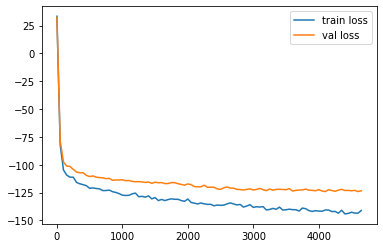

In [11]:
# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

## 5. Delete unnecessary checkpoints

In [14]:
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)